### Replicate Figure 5 from Deep Double Descent

Tasks
*  Train 3 Layer CNNs of widths 4, 8, 12, 16, ..., 32, 46, ..., 128, 192, 256 with 500K Steps of SGD on CIFAR-10 without data-augmentation, and with 10% added label noise.
*  Train 5 Layer CNNs of widths 4, 8, 12, 16, ..., 32, 46, 64 with 500K Steps of SGD on CIFAR-10 without data-augmentation, and with 10% added label noise.
*  Train 3 Layer CNNs of widths 2, 4, 6, ..., 14, 16 with 500K Steps of SGD on CIFAR-10 without data-augmentation, and with 10% added label noise.

Future Tasks:
*  Redo parts of the above using the lazy and active regime.

Notes:
* Depth 3 conv net with width 256 has approx 1.2 million parameters. 
* Depth 5 conv net with width 64 has approx 1.5 million parameters.
* depth 7 conv net with width 16 has approx 1.5 million parameters.

Interpolation is reached at ~600,000 parameters.
We want to cross compare # parameters, not the width value.


### This note book contains results from training depth 3 networks.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl

from models.conv_nets import make_convNet 
from utils.train_utils import timer, inverse_squareroot_lr
from utils.visualizations import plot_loss_from_file_convnets

# keeps tensorflow from using all available GPU memory when a model is initialized.
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

#### Train depth 3 conv nets at widths of [1, 2, 4, 8, ..., 32, 48, 64, 80, ... ,128, 192,  256]

In [ ]:
batch_size=128
n_epochs = 500_000 // (50_000 // 128) # total number desirec SGD steps / number batches per epoch

label_noise_int = 20
label_noise = label_noise_int / 100

cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# apply label noise to the data set
random_idx = np.random.choice(x_train.shape[0], int(label_noise*x_train.shape[0]))
rand_labels = np.random.randint(low=y_train.min(), high=y_train.max(), size=len(random_idx))
y_train[random_idx] = np.expand_dims(rand_labels, axis=1)

image_shape = x_train[0].shape

model_histories = {}
convnet_widths = [1, 2] + [4 * (i+1) for i in range(7)] + [32 + 16*(i) for i in range(7)] + [192, 256]
convnet_depth = 3

# Paths to save model weights and 
model_weights_paths = f'trained_model_weights/conv_nets_depth_{convnet_depth}_{label_noise_int}pct_noise/'
data_save_path = 'experimental_results/conv_nets_'

for width in convnet_widths:
    # Depth 3 Conv Net using default Kaiming Uniform Initialization.
    conv_net, model_id = make_convNet(image_shape, depth=convnet_depth, init_channels=width)

    conv_net.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=inverse_squareroot_lr()),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    model_timer = timer()
    
    print(f'STARTING TRAINING: {model_id}')
    history = conv_net.fit(
        x=x_train, y=y_train, 
        validation_data=(x_test, y_test),
        epochs=n_epochs,
        batch_size=batch_size,
        verbose=0, 
        callbacks = [model_timer]
    )
    print(f'FINISHED TRAINING: {model_id}')
    
    # add results to dictionary and store the resulting model weights.
    model_histories[model_id] = history
    history.model.save_weights(model_weights_paths+model_id)
    
    # clear GPU of prior model to decrease training times.
    tf.keras.backend.clear_session()
    
    
# store all the results in a pickle file for later graphing and analysis.
depth_3_metrics = {} 

for m_id, history in model_histories.items():
    depth_3_metrics[m_id] = history.history
    
pkl.dump(depth_3_metrics, open(data_save_path + f'depth_{convnet_depth}_{label_noise_int}pct_noise.pkl', 'wb'))

STARTING TRAINING: conv_net_depth_3_width_1
Epoch: 0000, Total Run Time: 00:00:04 - Loss: 2.2935e+00, Accuracy: 0.129, Test Loss: 2.2695e+00, Test Accuracy: 0.139


## Graph Results: Train & Test Loss and Accuracy at both end of training and at optimal early stopping.

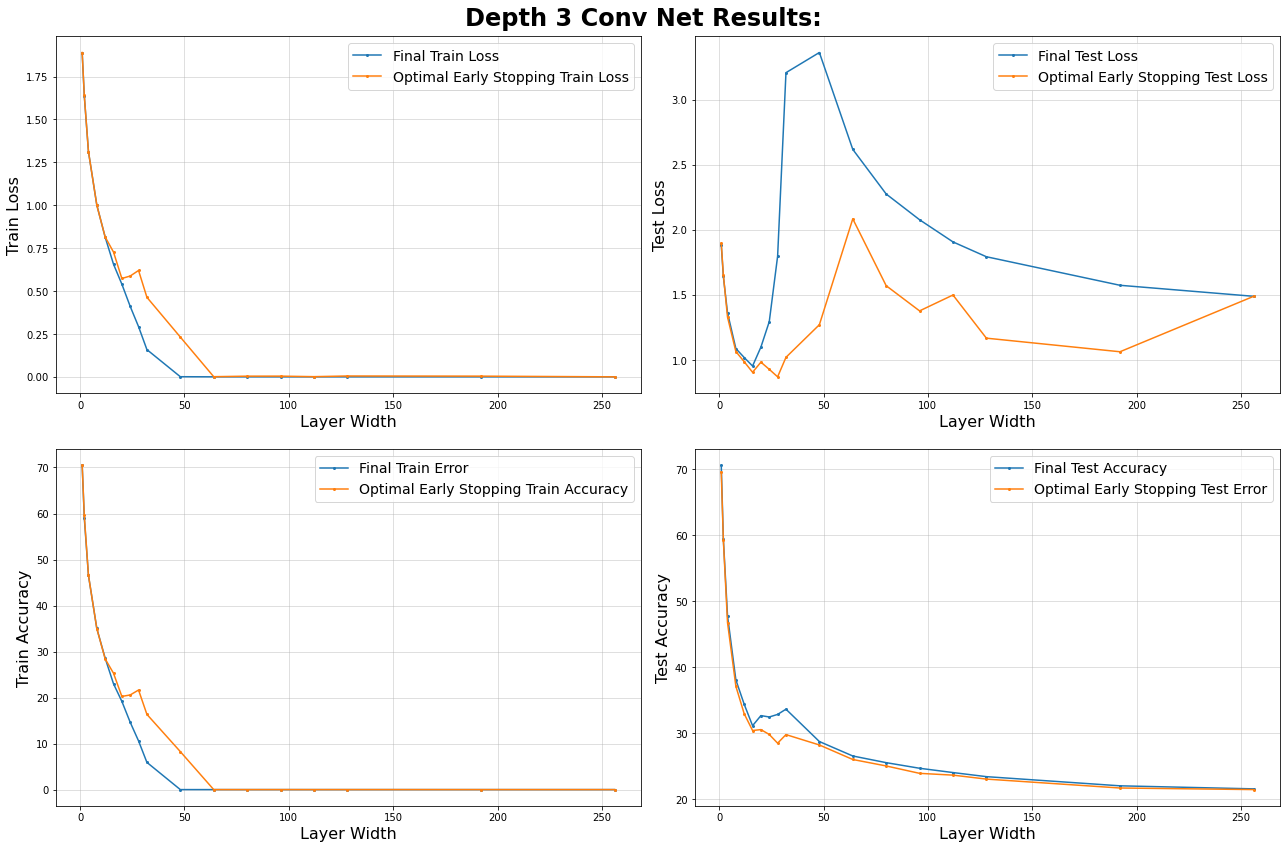

In [5]:
convnet_depth = 3
label_noise_int = 0
plot_path = f'experimental_results/conv_nets_depth_{convnet_depth}_{label_noise_int}pct_noise.pkl'
plot_loss_from_file_convnets(plot_path, depth=convnet_depth)

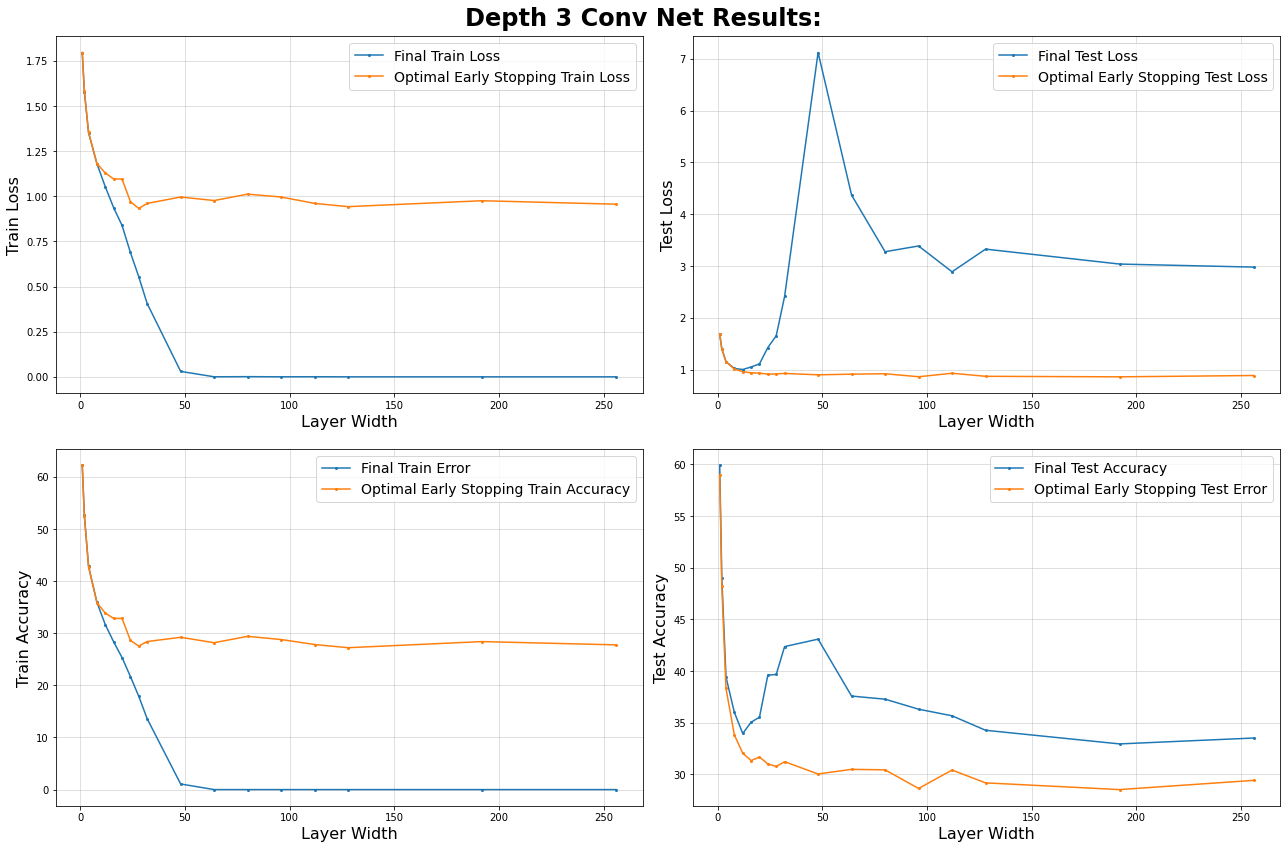

In [6]:
convnet_depth = 3
label_noise_int = 10
plot_path = f'experimental_results/conv_nets_depth_{convnet_depth}_{label_noise_int}pct_noise.pkl'
plot_loss_from_file_convnets(plot_path, depth=convnet_depth)